In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datetime import timedelta
from timeit import default_timer as timer
from math import sqrt

from random import choices
from scipy.linalg import null_space
from scipy.optimize import minimize

from PIL import ImageDraw

In [2]:
#img_l = np.asanyarray(Image.open("../lab1/hangerL-small.png").convert("RGB")).astype(np.int)
#img_r = np.asanyarray(Image.open("../lab1/hangerR-small.png").convert("RGB")).astype(np.int)
img_l = np.asanyarray(Image.open("../myL.jpg").convert("RGB").resize((320,180), Image.BICUBIC)).astype(np.int)
img_r = np.asanyarray(Image.open("../myR.jpg").convert("RGB").resize((320,180), Image.BICUBIC)).astype(np.int)
img_shift = np.load("../lab1/img_shift.npy")

bestF = np.load("../lab2/bestF.npy")

In [3]:
def draw(img_r, epipole):
    image2show = Image.fromarray(img_r.astype(np.uint8))
    draw = ImageDraw.Draw(image2show)
    focus_x, focus_y = img_r.shape[1]//2, img_r.shape[0]//2

    epipole2 = epipole.reshape(3) + np.array([img_r.shape[1]//2, img_r.shape[0]//2, 0])

    x_img = img_r.shape[1]
    for y_img in range(0, img_r.shape[0], 30):
        diff_vector = np.array([x_img, y_img, 1]) - epipole2.reshape(3)
        x_line1, y_line1, z_line1 = epipole2.reshape(3) + (1/3)*diff_vector
        x_line2, y_line2, z_line2 = epipole2.reshape(3) + (2/3)*diff_vector

        focus2point = np.array([x_line1, y_line1, z_line1]) - np.array([focus_x, focus_y, 0])
        projected_p1 = np.array([focus_x, focus_y, 0]) + focus2point*(1/focus2point[-1])

        focus2point = np.array([x_line2, y_line2, z_line2]) - np.array([focus_x, focus_y, 0])
        projected_p2 = np.array([focus_x, focus_y, 0]) + focus2point*(1/focus2point[-1])


        projected_diff = projected_p1 - projected_p2

        projected_p1 = projected_p1 - 1000*projected_diff
        projected_p2 = projected_p2 + 1000*projected_diff

        draw.line((*projected_p1[:-1], *projected_p2[:-1]), fill=128)

    y_img = 0
    for x_img in range(0, img_r.shape[1], 30):
        diff_vector = np.array([x_img, y_img, 1]) - epipole2.reshape(3)
        x_line1, y_line1, z_line1 = epipole2.reshape(3) + (1/3)*diff_vector
        x_line2, y_line2, z_line2 = epipole2.reshape(3) + (2/3)*diff_vector

        focus2point = np.array([x_line1, y_line1, z_line1]) - np.array([focus_x, focus_y, 0])
        projected_p1 = np.array([focus_x, focus_y, 0]) + focus2point*(1/focus2point[-1])

        focus2point = np.array([x_line2, y_line2, z_line2]) - np.array([focus_x, focus_y, 0])
        projected_p2 = np.array([focus_x, focus_y, 0]) + focus2point*(1/focus2point[-1])

        projected_diff = projected_p1 - projected_p2

        projected_p1 = projected_p1 - 1000*projected_diff
        projected_p2 = projected_p2 + 1000*projected_diff

        draw.line((*projected_p1[:-1], *projected_p2[:-1]), fill=128)

    return image2show

In [4]:
img_r_with_lines = draw(img_r, -null_space(bestF))
img_r_with_lines = np.asarray(img_r_with_lines)

In [5]:
img_r_with_lines.shape

(180, 320, 3)

In [10]:
epipole = null_space(bestF)
epipole = epipole[:,0]

k = np.array([0,0,1])
r3 = k.copy()
r2 = np.cross(r3, epipole/np.linalg.norm(epipole))
r1 = np.cross(r2, r3)
print(r1,r2,r3)
R_right = np.array([r1, r2, r3])
print("\n", R_right)

epipole_strich = np.dot(R_right, epipole)
G_right = np.array([[1, 0, 0],
                    [0, 1, 0],
                    [-epipole_strich[2]/epipole_strich[0], 0, 1]])
print(G_right)

Right_Combined = np.dot(G_right, R_right)
Right_Combined_inv = np.linalg.inv(Right_Combined)

[ 0.70710678 -0.70710678  0.        ] [ 0.70710678  0.70710678 -0.        ] [0 0 1]

 [[ 0.70710678 -0.70710678  0.        ]
 [ 0.70710678  0.70710678 -0.        ]
 [ 0.          0.          1.        ]]
[[1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [3.28626015e-14 0.00000000e+00 1.00000000e+00]]


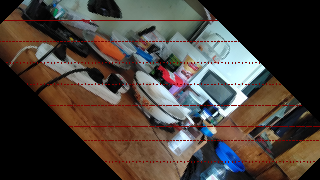

In [11]:
new_right = np.zeros(img_r.shape, dtype=np.uint8)
x_shift = new_right.shape[1]//2
y_shift = new_right.shape[0]//2
for y in range(new_right.shape[0]):
    for x in range(new_right.shape[1]):
        x2, y2, z2 = np.dot(Right_Combined_inv, np.array([x-x_shift,y-y_shift,1]))
        x2 = x2*(1/z2)
        y2 = y2*(1/z2)
        if 0 <= x2 + x_shift < img_r.shape[1] and 0 <= y2 + y_shift < img_r.shape[0]:
            new_right[y, x] = img_r_with_lines[int(y2 + y_shift), int(x2 + x_shift)]
Image.fromarray(new_right)

In [12]:
mat_e = np.array([[0, -epipole[2], epipole[1]],
                  [epipole[2], 0, -epipole[0]],
                  [-epipole[1], epipole[0], 0]])

m = np.dot(Right_Combined, np.dot(mat_e, bestF))
m_strich = np.array([np.cross(m[1], m[2])/sqrt(np.linalg.norm(np.cross(m[1], m[2]))),
                     m[1],
                     m[2]])

In [13]:
def p(x):
    return x/x[2]

def is_smooth(img_shift, x, y, radius=1):
    for i in range(-radius,radius+1):
        for j in range(-radius,radius+1):
            if np.any(img_shift[y, x] != img_shift[y+i, x+j]):
                return False
    return True

pairs = []
for y_r in range(30, img_r.shape[0] - 30):
    for x_r in range(30, img_r.shape[1] - 30):
        x_r3d = [x_r - img_r.shape[1]//2, y_r - img_r.shape[0]//2, 1]
        
        dot_shift = img_shift[y_r, x_r]
        
        x_l = int(x_r + dot_shift[0])
        y_l = int(y_r + dot_shift[1])
        x_l3d = [x_l - img_r.shape[1]//2, y_l - img_r.shape[0]//2, 1]
        
        if is_smooth(img_shift, x_r, y_r):
            pairs.append([x_l3d, x_r3d])

all_right = np.array([i[1] for i in pairs])
all_left = np.array([i[0] for i in pairs])

a = []
for r, l in zip(all_right, all_left):
    a.append(np.sum(np.abs(img_l[l[1]+y_shift,l[0]+x_shift] - img_r[r[1]+y_shift, r[0]+x_shift])))
print(sum(a)/len(a))

def f(x):
    a,b,c = x
    ans = 0
    for r, l in zip(all_right, all_left):
        f1 = np.dot(x, p(np.dot(m_strich, r)))
        f2 = np.dot(np.array([1,0,0]), p(np.dot(Right_Combined, l)))
        ans += (f1 - f2)**2
    return ans

x0 = np.array([1,0,0])
result = minimize(f, x0, method='nelder-mead')
answer = result.x

Left_Combined = np.dot(np.array([answer, [0,1,0], [0,0,1]]), m_strich)
Left_Combined_inv = np.linalg.inv(Left_Combined)

18.253760627861347


In [14]:
img_l_with_lines = draw(img_l, -null_space(bestF.T))
img_l_with_lines = np.asarray(img_l_with_lines)

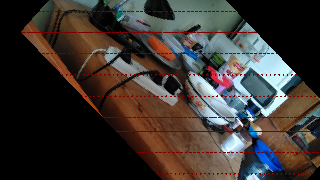

In [15]:
new_left = np.zeros(img_l.shape, dtype=np.uint8)

x_shift = new_left.shape[1]//2
y_shift = new_left.shape[0]//2
for y in range(new_left.shape[0]):
    for x in range(new_left.shape[1]):
        x2, y2, z2 = np.dot(Left_Combined_inv, np.array([x-x_shift,y-y_shift,1]))
        x2 = x2*(1/z2)
        y2 = y2*(1/z2)
        if 0 <= x2 + x_shift < img_l.shape[1] and 0 <= y2 + y_shift < img_l.shape[0]:
            new_left[y, x] = img_l_with_lines[int(y2 + y_shift), int(x2 + x_shift)]
Image.fromarray(new_left)

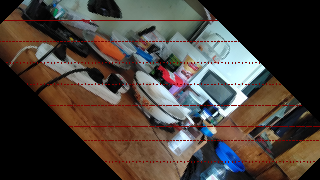

In [16]:
new_right = np.zeros(img_r.shape, dtype=np.uint8)
x_shift = new_right.shape[1]//2
y_shift = new_right.shape[0]//2
for y in range(new_right.shape[0]):
    for x in range(new_right.shape[1]):
        x2, y2, z2 = np.dot(Right_Combined_inv, np.array([x-x_shift,y-y_shift,1]))
        x2 = x2*(1/z2)
        y2 = y2*(1/z2)
        if 0 <= x2 + x_shift < img_r.shape[1] and 0 <= y2 + y_shift < img_r.shape[0]:
            new_right[y, x] = img_r_with_lines[int(y2 + y_shift), int(x2 + x_shift)]
Image.fromarray(new_right)

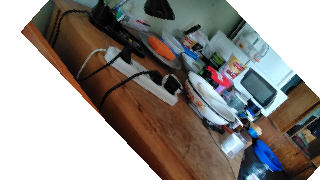

In [17]:
new_left = 255*np.ones(img_l.shape, dtype=np.uint8)

x_shift = new_left.shape[1]//2
y_shift = new_left.shape[0]//2
for y in range(new_left.shape[0]):
    for x in range(new_left.shape[1]):
        x2, y2, z2 = np.dot(Left_Combined_inv, np.array([x-x_shift,y-y_shift,1]))
        x2 = x2*(1/z2)
        y2 = y2*(1/z2)
        if 0 <= x2 + x_shift < img_l.shape[1] and 0 <= y2 + y_shift < img_l.shape[0]:
            new_left[y, x] = img_l[int(y2 + y_shift), int(x2 + x_shift)]
Image.fromarray(new_left).save("hangerL-small.png")
Image.fromarray(new_left)

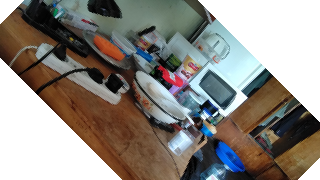

In [18]:
new_right = 255*np.ones(img_r.shape, dtype=np.uint8)
x_shift = new_right.shape[1]//2
y_shift = new_right.shape[0]//2
for y in range(new_right.shape[0]):
    for x in range(new_right.shape[1]):
        x2, y2, z2 = np.dot(Right_Combined_inv, np.array([x-x_shift,y-y_shift,1]))
        x2 = x2*(1/z2)
        y2 = y2*(1/z2)
        if 0 <= x2 + x_shift < img_r.shape[1] and 0 <= y2 + y_shift < img_r.shape[0]:
            new_right[y, x] = img_r[int(y2 + y_shift), int(x2 + x_shift)]
Image.fromarray(new_right).save("hangerR-small.png")
Image.fromarray(new_right)